In [4]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [6]:
def create_label(click,buy):
    if buy == 1:
        return 5
    elif click == 1:
        return 1
    else:
        return 0

In [7]:
# create data and label
data = df[test.columns] 
label = df['click_bool'].combine(df['booking_bool'], create_label)

In [9]:
# The original data is two large, we test our model via 10% data
from sklearn.cross_validation import train_test_split
one , data_sample, two, label_sample  = train_test_split(data, label, 
                                                         test_size=0.1, random_state=123, stratify=label)

In [10]:
# remove the index column
data_sample_noindex = data_sample.drop(['srch_id', 'prop_id'], axis=1)

In [11]:
# deal with string feature. xgboost can only deal with numeric feature
from sklearn.preprocessing import LabelEncoder
series = data_sample_noindex['date_time']
en = LabelEncoder()
series = pd.Series(en.fit_transform(series), index=series.index)
data_sample_noindex['date_time'] = series

In [13]:
# split the data into training data and test data
train_data , test_data, train_label, test_label  = train_test_split(data_sample_noindex, label_sample, 
                                                         test_size=0.2, random_state=345, stratify=label_sample)

In [22]:
# test two models
import xgboost as xgb
gbm = xgb.XGBRegressor(objective='rank:pairwise')
#gbm = xgb.XGBRegressor()
gbm.fit(train_data, train_label,
        eval_set =[(train_data, train_label), (test_data, test_label)], 
        eval_metric="ndcg@38", verbose=True)

[0]	validation_0-ndcg@38:0.083192	validation_1-ndcg@38:0.217357
[1]	validation_0-ndcg@38:0.083192	validation_1-ndcg@38:0.217357
[2]	validation_0-ndcg@38:0.065215	validation_1-ndcg@38:0.217493
[3]	validation_0-ndcg@38:0.087546	validation_1-ndcg@38:0.108224
[4]	validation_0-ndcg@38:0.108596	validation_1-ndcg@38:0.134816
[5]	validation_0-ndcg@38:0.144165	validation_1-ndcg@38:0.125137
[6]	validation_0-ndcg@38:0.146741	validation_1-ndcg@38:0.125137
[7]	validation_0-ndcg@38:0.146741	validation_1-ndcg@38:0.125137
[8]	validation_0-ndcg@38:0.213046	validation_1-ndcg@38:0.14515
[9]	validation_0-ndcg@38:0.222306	validation_1-ndcg@38:0.17942
[10]	validation_0-ndcg@38:0.222306	validation_1-ndcg@38:0.17942
[11]	validation_0-ndcg@38:0.222306	validation_1-ndcg@38:0.17942
[12]	validation_0-ndcg@38:0.222306	validation_1-ndcg@38:0.17942
[13]	validation_0-ndcg@38:0.222306	validation_1-ndcg@38:0.17942
[14]	validation_0-ndcg@38:0.222306	validation_1-ndcg@38:0.17942
[15]	validation_0-ndcg@38:0.276622	validat

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='rank:pairwise', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

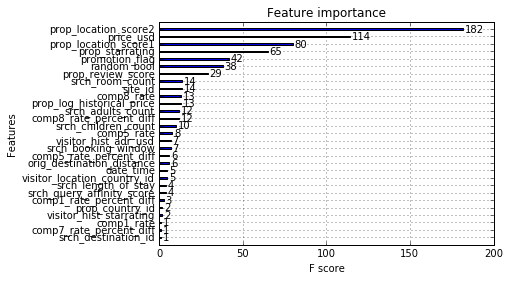

In [24]:
# check which parameters are not important
%matplotlib inline
xgb.plot_importance(gbm.booster())
result = gbm.booster().get_fscore()

In [31]:
# remove the useless features
se = pd.Series(result)
important_feature = se[lambda x: x>10].index

In [32]:
# split again
train_data , test_data, train_label, test_label  = train_test_split(data_sample_noindex[important_feature], label_sample, 
                                                         test_size=0.2, random_state=345, stratify=label_sample)

In [49]:
# retrain
import xgboost as xgb
#gbm = xgb.XGBRegressor(objective='rank:pairwise')
gbm = xgb.XGBRegressor()
gbm.fit(train_data, train_label,
        eval_set =[(train_data, train_label), (test_data, test_label)], 
        eval_metric="ndcg@38", verbose=True)


[0]	validation_0-ndcg@38:0.231507	validation_1-ndcg@38:0.119377
[1]	validation_0-ndcg@38:0.231507	validation_1-ndcg@38:0.119377
[2]	validation_0-ndcg@38:0.231507	validation_1-ndcg@38:0.119377
[3]	validation_0-ndcg@38:0.139848	validation_1-ndcg@38:0.120561
[4]	validation_0-ndcg@38:0.271074	validation_1-ndcg@38:0.254019
[5]	validation_0-ndcg@38:0.271074	validation_1-ndcg@38:0.254019
[6]	validation_0-ndcg@38:0.271074	validation_1-ndcg@38:0.254019
[7]	validation_0-ndcg@38:0.271074	validation_1-ndcg@38:0.254019
[8]	validation_0-ndcg@38:0.271074	validation_1-ndcg@38:0.254019
[9]	validation_0-ndcg@38:0.354652	validation_1-ndcg@38:0.273096
[10]	validation_0-ndcg@38:0.354652	validation_1-ndcg@38:0.273096
[11]	validation_0-ndcg@38:0.354652	validation_1-ndcg@38:0.273096
[12]	validation_0-ndcg@38:0.424574	validation_1-ndcg@38:0.403007
[13]	validation_0-ndcg@38:0.556233	validation_1-ndcg@38:0.519842
[14]	validation_0-ndcg@38:0.556233	validation_1-ndcg@38:0.519842
[15]	validation_0-ndcg@38:0.556233	

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [59]:
# test the ndcg to see if the value is the same as we implemented
result = pd.Series(gbm.predict(test_data), index=test_data.index)
import ndcg
new_index=result.sort_values(ascending=False).index
r = test_label.reindex(index=new_index)
#test_label.sort_values(ascending=False)
ndcg.ndcg_at_k(r,38)

0.43068500678724025